In [1]:
%cd ~/cdv/
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import jax.numpy as jnp
import jax
import jax.random as jr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import wat
from eins import EinsOp
import treescope


is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/nmiklaucic/cdv


gamma
(9.568116731031246, -0.021411738147320863, 0.34823974495667276)
-1.457


<Axes: ylabel='Density'>

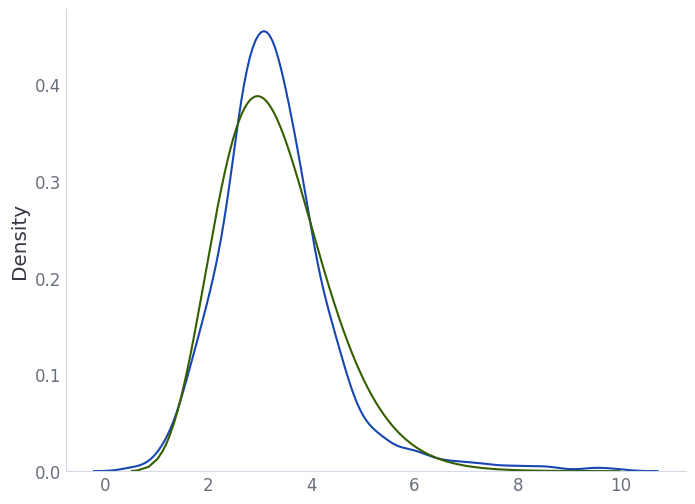

In [2]:
import json

with open('precomputed/mptrj/metadata.json') as f:
    metadata = json.load(f)

centers = np.array(metadata['distances']['bins'])
total_counts = np.array(metadata['distances']['counts'])

bin_diameter = centers[1] - centers[0]
bin_rad = bin_diameter / 2

counts = np.rint(total_counts / sum(total_counts) * 2048).astype(int)
samples = []

rng = np.random.default_rng(29205)
for center, count in zip(centers, counts):
    samples.extend(rng.uniform(center - bin_rad, center + bin_rad, (count,)))

samples = jnp.array(samples)
samples

import scipy.stats.distributions as scipy_dist

dist_fits = {}
for dist_name in 'gamma'.split(' '):
    dist = getattr(scipy_dist, dist_name)
    fit = dist.fit(samples)
    dist_fit = dist(*fit)
    dist_fits[dist_name] = (dist_fit)
    print(dist_name)
    print(fit)
    print(round(dist_fit.logpdf(samples).mean(), 3))


sns.kdeplot(samples)
sns.lineplot(x=samples, y=dist_fits[dist_name].pdf(samples))

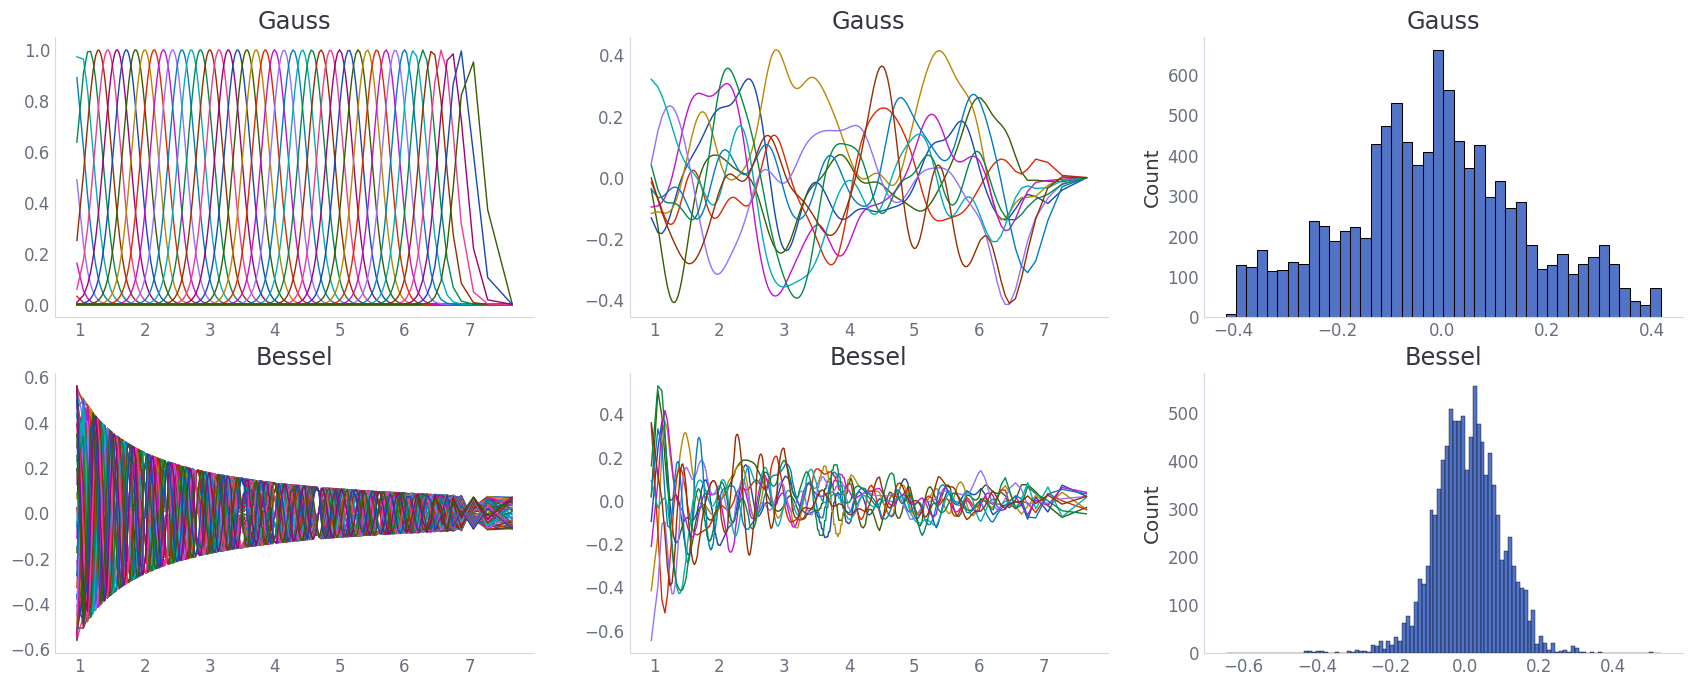

In [11]:
from facet.mace.edge_embedding import GaussBasis, BesselBasis, RadialBasis
from facet.layers import Context
from numpyro import distributions as dist

r_dist = dist.Gamma(dist_fits['gamma'].args[0], 1 / dist_fits['gamma'].args[-1])

ctx = Context(training=False)

rmax = 7
qq = jnp.linspace(0, 1, 1002)[1:-1]
rr = r_dist.icdf(qq).astype(jnp.bfloat16)

num_basis = 50

bases = {
    'Gauss': GaussBasis(num_basis=num_basis, mu_max=rmax, sd=0.2, mu_trainable=False, sd_trainable=False),
    'Bessel': BesselBasis(num_basis=num_basis, freq_trainable=False)
}

coefs = np.random.randn(num_basis, 10)
coefs = coefs / coefs.shape[-1]

fig, axs = plt.subplots(len(bases), 3, figsize=(3 * 7, len(bases) * 4), squeeze=False)

for (name, base), row in zip(bases.items(), axs):
    ax1, ax2, ax3 = row
    for ax in row:
        ax.set_title(name)

    out, params = base.init_with_output(jr.key(234), rr, r_max=rmax, ctx=ctx)
    ax1.plot(rr, out, lw=1)
    ax2.plot(rr, out @ coefs, lw=1)    
    sns.histplot((out @ coefs).reshape(-1), ax=ax3)